In [1]:
import json
from src.model.models.BasicXGBOOST1 import BasicXGBOOST1
from src.features.featurizer import Featurizer2
from src.dataset.dataset2 import Dataset2
import numpy as np
import pandas as pd

In [ ]:
feat = Featurizer2()
feat.process()

In [2]:
dataset = Dataset2(
        sequence_length=100, predict_horizon=10
    )
X_train, X_test, y_train, y_test, times_train, times_test = dataset.get_train_test()
model = BasicXGBOOST1()
model.init_model()
model.fit(X_train, y_train)


100%|██████████| 12/12 [00:29<00:00,  2.46s/it]


(122571, 8400) (122571,) (122571, 100)


/Users/carloteufel/Documents/Projects/FeatureEngineering/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/carloteufel/Documents/Projects/FeatureEngineering/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/carloteufel/Documents/Projects/FeatureEngineering/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [3]:
import shap

xgb = model.xgb_pipeline.named_steps['xgb']
transform = model.xgb_pipeline.named_steps['scaler']

X_modified = transform.transform(X_test)

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_modified)


/Users/carloteufel/Documents/Projects/FeatureEngineering/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
print(len(dataset.columns))
extended_columns = []
for i in range(100):
    extended_columns.extend([f"{name}_{i}" for name in dataset.columns])

print("extended_columns", extended_columns)

84
extended_columns ['open_0', 'high_0', 'low_0', 'close_0', 'volume_0', 'sma_5_0', 'sma_10_0', 'sma_20_0', 'sma_30_0', 'sma_60_0', 'sma_200_0', 'ema_12_0', 'ema_26_0', 'ema_50_0', 'ema_200_0', 'rsi_14_0', 'rsi_30_0', 'rsi_50_0', 'vwap_typical_ohlcv_0', 'lowest_low_0', 'highest_high_0', 'stochastic_k_0', 'stochastic_d_0', 'mean_bid_0', 'mean_ask_0', 'std_bid_0', 'std_ask_0', 'median_ask_0', 'median_bid_0', 'mean_spread_0', 'std_spread_0', 'median_spread_0', 'total_bid_size_0', 'total_ask_size_0', 'max_spread_0', 'min_spread_0', 'mean_spread_change_0', 'std_spread_change_0', 'median_spread_change_0', 'volume_avg_price_0', 'time_avg_price_0', 'order_book_imbalance_0', 'order_book_imbalance_change_0', 'order_book_imbalance_std_0', 'order_book_imbalance_median_0', 'order_book_imbalance_avg_0', 'order_book_imbalance_max_0', 'order_book_imbalance_min_0', 'order_book_imbalance_change_std_0', 'order_book_imbalance_change_median_0', 'order_book_imbalance_change_avg_0', 'bid_ask_ratio_0', 'bid_a

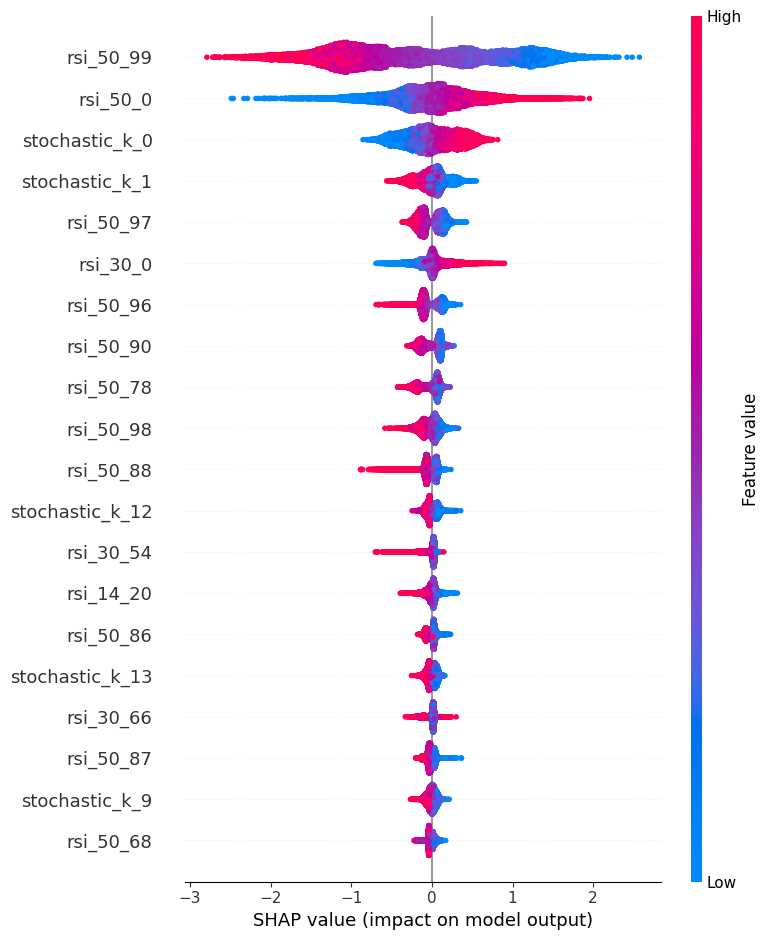

In [7]:
class_idx = 2
X_scaled_df = pd.DataFrame(X_modified[:,:], columns=extended_columns)
shap.summary_plot(shap_values[:,:,class_idx], X_scaled_df)
